<a href="https://colab.research.google.com/github/Vamsikrii/Phishing-Website-Detection-using-ML-Algorithms/blob/main/Copy_of_URL_Phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score
import sklearn.metrics as metrics
from scipy.stats import randint, uniform
import pickle
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load Dataset

In [ ]:
df = pd.read_csv('/content/dataset_phishing.csv')

# Data Cleaning and Preprocessing

In [ ]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [ ]:
df.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [ ]:
df['status'].value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

In [ ]:
#change status into int dtype with legitimate as 0 and phishing as 1
mapping = {'legitimate':0, 'phishing':1}

df['status'] = df['status'].map(mapping)

In [ ]:
df['status'].value_counts()

status
0    5715
1    5715
Name: count, dtype: int64

In [ ]:
corr_matrix = df.corr(numeric_only=True)
corr_matrix

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
length_url,1.000000,0.223025,0.453961,0.443589,0.399564,0.150739,0.520930,0.576268,NaN,0.621745,...,0.125159,-0.006476,-0.007082,0.002799,-0.006798,0.072205,0.023357,0.236395,-0.102582,0.248580
length_hostname,0.223025,1.000000,0.252013,0.408956,0.057702,0.071793,0.162400,0.145617,NaN,0.183405,...,0.217284,0.074707,-0.097794,-0.041081,0.013854,0.163238,-0.023344,0.213990,-0.159342,0.238322
ip,0.453961,0.252013,1.000000,0.288398,0.109860,0.059401,0.405434,0.383262,NaN,0.440972,...,0.137716,0.014561,0.053246,-0.108869,-0.077020,0.167930,0.127823,0.270743,-0.218968,0.321698
nb_dots,0.443589,0.408956,0.288398,1.000000,0.045099,0.263283,0.347411,0.435798,NaN,0.414902,...,0.107789,0.055560,0.056407,-0.024117,-0.007818,0.087969,0.126659,0.209616,-0.097312,0.207029
nb_hyphens,0.399564,0.057702,0.109860,0.045099,1.000000,0.018770,0.036804,0.120487,NaN,0.107050,...,0.006909,0.020297,-0.055794,0.038163,0.080104,-0.041464,-0.031477,-0.018828,0.104341,-0.100107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
web_traffic,0.072205,0.163238,0.167930,0.087969,-0.041464,-0.009459,0.143777,0.164797,NaN,0.187809,...,0.081786,0.083888,0.022598,-0.110435,-0.096698,1.000000,-0.007113,0.034099,-0.209526,0.060388
dns_record,0.023357,-0.023344,0.127823,0.126659,-0.031477,0.031611,0.009441,0.076372,NaN,0.052159,...,0.062084,0.043817,0.213899,-0.060811,-0.068023,-0.007113,1.000000,0.096413,-0.142135,0.122119
google_index,0.236395,0.213990,0.270743,0.209616,-0.018828,0.113217,0.201260,0.129093,NaN,0.167385,...,0.267465,-0.143655,0.040633,-0.134656,-0.210111,0.034099,0.096413,1.000000,-0.389887,0.731171
page_rank,-0.102582,-0.159342,-0.218968,-0.097312,0.104341,-0.066356,-0.123852,-0.126164,NaN,-0.133089,...,-0.330810,0.058843,-0.155990,0.345751,0.589602,-0.209526,-0.142135,-0.389887,1.000000,-0.511137


In [ ]:
target_corr = corr_matrix['status']
target_corr

length_url         0.248580
length_hostname    0.238322
ip                 0.321698
nb_dots            0.207029
nb_hyphens        -0.100107
                     ...   
web_traffic        0.060388
dns_record         0.122119
google_index       0.731171
page_rank         -0.511137
status             1.000000
Name: status, Length: 88, dtype: float64

In [ ]:
#only choose features with abs value > 0.1

threshold=0.1
relevant_features = target_corr[abs(target_corr)>threshold].index.tolist()
relevant_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_eq',
 'nb_slash',
 'nb_semicolumn',
 'nb_www',
 'nb_com',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'shortening_service',
 'length_words_raw',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'ratio_extRedirection',
 'external_favicon',
 'links_in_tags',
 'ratio_intMedia',
 'ratio_extMedia',
 'safe_anchor',
 'empty_title',
 'domain_in_title',
 'domain_with_copyright',
 'domain_registration_length',
 'domain_age',
 'dns_record',
 'google_index',
 'page_rank',
 'status']

In [ ]:
#only select relevant features

X = df[relevant_features]
X = X.drop('status', axis=1)
y = df['status']

In [ ]:
X.head()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_eq,nb_slash,...,ratio_extMedia,safe_anchor,empty_title,domain_in_title,domain_with_copyright,domain_registration_length,domain_age,dns_record,google_index,page_rank
0,37,19,0,3,0,0,0,0,0,3,...,0.000000,0.0,0,0,1,45,-1,1,1,4
1,77,23,1,1,0,0,0,0,0,5,...,20.000000,100.0,0,1,0,77,5767,0,1,2
2,126,50,1,4,1,0,1,2,3,5,...,0.000000,100.0,0,1,0,14,4004,0,1,0
3,18,11,0,2,0,0,0,0,0,2,...,3.571429,62.5,0,1,0,62,-1,0,0,3
4,55,15,0,2,2,0,0,0,0,5,...,100.000000,0.0,0,0,1,224,8175,0,0,6


In [ ]:
y.head()

0    0
1    1
2    1
3    0
4    0
Name: status, dtype: int64

# Model Development

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled,y_train)

RandomForestClassifier()

In [ ]:
rf_predict = rf.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test,rf_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:96%


In [ ]:
rf_Accuracy_Score = accuracy_score(y_test,rf_predict)
rf_JaccardIndex = jaccard_score(y_test,rf_predict)
rf_F1_Score = f1_score(y_test,rf_predict)
rf_Log_Loss = log_loss(y_test,rf_predict)
rf_Precision = precision_score(y_test,rf_predict)
rf_Recall = recall_score(y_test, rf_predict)

In [ ]:
print(f"Accuracy: {rf_Accuracy_Score}")
print(f"Jaccard Index: {rf_JaccardIndex}")
print(f"F1 Score: {rf_F1_Score}")
print(f"Log Loss: {rf_Log_Loss}")
print(f"Precision:{rf_Precision}")
print(f"Recall: {rf_Recall}")

Accuracy: 0.9645669291338582
Jaccard Index: 0.9303525365434222
F1 Score: 0.9639198218262806
Log Loss: 1.2771373248112379
Precision:0.9695340501792115
Recall: 0.95837023914969


In [ ]:
rf_conf_matrix = confusion_matrix(y_test,rf_predict)
rf_conf_matrix

array([[1123,   34],
       [  47, 1082]])

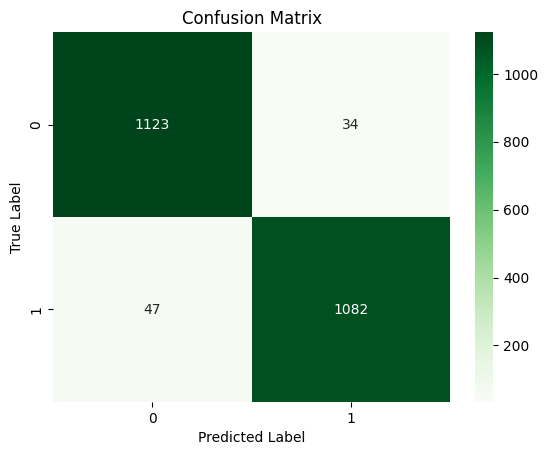

In [ ]:
sns.heatmap(rf_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
rf_report = classification_report(y_test,rf_predict)
print(rf_report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1157
           1       0.97      0.96      0.96      1129

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286



## SVM

In [ ]:
svm = SVC()
svm.fit(X_train_scaled,y_train)

SVC()

In [ ]:
svm_predict = svm.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test,svm_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:97%


In [ ]:
svm_Accuracy_Score = accuracy_score(y_test,svm_predict)
svm_JaccardIndex = jaccard_score(y_test,svm_predict)
svm_F1_Score = f1_score(y_test,svm_predict)
svm_Log_Loss = log_loss(y_test,svm_predict)
svm_Precision = precision_score(y_test,rf_predict)
svm_Recall = recall_score(y_test, rf_predict)

In [ ]:
print(f"Accuracy: {svm_Accuracy_Score}")
print(f"Jaccard Index: {svm_JaccardIndex}")
print(f"F1 Score: {svm_F1_Score}")
print(f"Log Loss: {svm_Log_Loss}")
print(f"Precision:{svm_Precision}")
print(f"Recall: {svm_Recall}")

Accuracy: 0.9654418197725284
Jaccard Index: 0.9321888412017167
F1 Score: 0.9649044868947134
Log Loss: 1.2456030698776273
Precision:0.9695340501792115
Recall: 0.95837023914969


In [ ]:
svm_conf_matrix = confusion_matrix(y_test,svm_predict)
svm_conf_matrix

array([[1121,   36],
       [  43, 1086]])

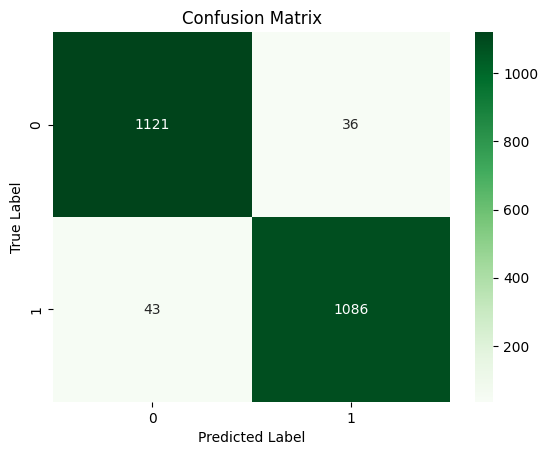

In [ ]:
sns.heatmap(svm_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
svm_report = classification_report(y_test,svm_predict)
print(svm_report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97      1157
           1       0.97      0.96      0.96      1129

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



## XGBoost

In [ ]:
params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'gamma': 0,
    'objective': 'binary:logistic'
}

In [ ]:
xgb = XGBClassifier(**params)
xgb.fit(X_train_scaled,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_predict = xgb.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test,xgb_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:95%


In [ ]:
xgb_Accuracy_Score = accuracy_score(y_test,xgb_predict)
xgb_JaccardIndex = jaccard_score(y_test,xgb_predict)
xgb_F1_Score = f1_score(y_test,xgb_predict)
xgb_Log_Loss = log_loss(y_test,xgb_predict)
xgb_Precision = precision_score(y_test,rf_predict)
xgb_Recall = recall_score(y_test, rf_predict)

In [ ]:
print(f"Accuracy: {xgb_Accuracy_Score}")
print(f"Jaccard Index: {xgb_JaccardIndex}")
print(f"F1 Score: {xgb_F1_Score}")
print(f"Log Loss: {xgb_Log_Loss}")
print(f"Precision:{xgb_Precision}")
print(f"Recall: {xgb_Recall}")

Accuracy: 0.9466316710411199
Jaccard Index: 0.8983333333333333
F1 Score: 0.9464442493415276
Log Loss: 1.9235895509502592
Precision:0.9695340501792115
Recall: 0.95837023914969


In [ ]:
xgb_conf_matrix = confusion_matrix(y_test,xgb_predict)
xgb_conf_matrix

array([[1086,   71],
       [  51, 1078]])

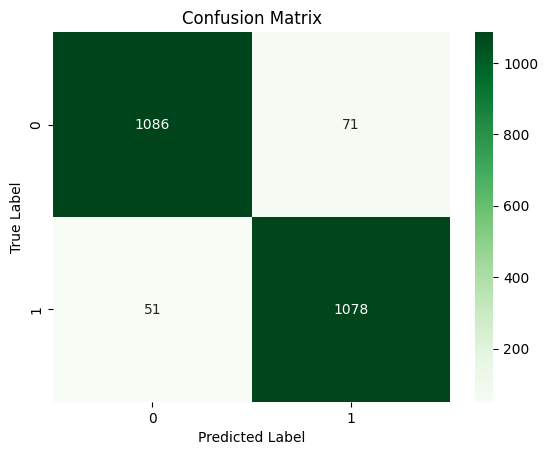

In [ ]:
sns.heatmap(xgb_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
xgb_report = classification_report(y_test,xgb_predict)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1157
           1       0.94      0.95      0.95      1129

    accuracy                           0.95      2286
   macro avg       0.95      0.95      0.95      2286
weighted avg       0.95      0.95      0.95      2286



# Decision Tree

In [ ]:
tree = DecisionTreeClassifier()  # Instantiate the Decision Tree model
tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [ ]:
tree_predict = tree.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test,tree_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:91%


In [ ]:
tree_Accuracy_Score = accuracy_score(y_test,tree_predict)
tree_JaccardIndex = jaccard_score(y_test,tree_predict)
tree_F1_Score = f1_score(y_test,tree_predict)
tree_Log_Loss = log_loss(y_test,tree_predict)
tree_Precision = precision_score(y_test,rf_predict)
tree_Recall = recall_score(y_test, rf_predict)

In [ ]:
print(f"Accuracy: {tree_Accuracy_Score}")
print(f"Jaccard Index: {tree_JaccardIndex}")
print(f"F1 Score: {tree_F1_Score}")
print(f"Log Loss: {tree_Log_Loss}")
print(f"Precision:{tree_Precision}")
print(f"Recall: {tree_Recall}")

Accuracy: 0.9090113735783028
Jaccard Index: 0.8296478296478297
F1 Score: 0.9068934646374218
Log Loss: 3.2795625130955237
Precision:0.9695340501792115
Recall: 0.95837023914969


In [ ]:
tree_conf_matrix = confusion_matrix(y_test,tree_predict)
tree_conf_matrix

array([[1065,   92],
       [ 116, 1013]])

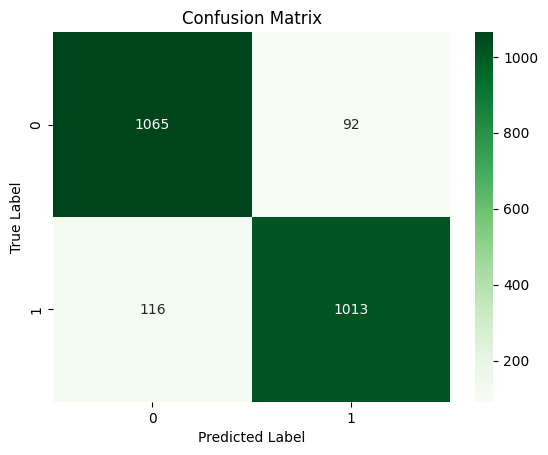

In [ ]:
sns.heatmap(tree_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
tree_report = classification_report(y_test,tree_predict)
print(tree_report)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1157
           1       0.92      0.90      0.91      1129

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



# NN with Backpropagation

In [ ]:
nn = MLPClassifier()
nn.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [ ]:
nn_predict = nn.predict(X_test_scaled)

In [ ]:
accuracy = accuracy_score(y_test,nn_predict)
print("Accuracy:{}%".format(round(accuracy *100), 1))

Accuracy:96%


In [ ]:
nn_Accuracy_Score = accuracy_score(y_test,nn_predict)
nn_JaccardIndex = jaccard_score(y_test,nn_predict)
nn_F1_Score = f1_score(y_test,nn_predict)
nn_Log_Loss = log_loss(y_test,nn_predict)
nn_Precision = precision_score(y_test,nn_predict)
nn_Recall = recall_score(y_test, nn_predict)

In [ ]:
print(f"Accuracy: {nn_Accuracy_Score}")
print(f"Jaccard Index: {nn_JaccardIndex}")
print(f"F1 Score: {nn_F1_Score}")
print(f"Log Loss: {nn_Log_Loss}")
print(f"Precision:{nn_Precision}")
print(f"Recall: {nn_Recall}")

Accuracy: 0.958005249343832
Jaccard Index: 0.9185059422750425
F1 Score: 0.9575221238938053
Log Loss: 1.5136442368133187
Precision:0.9566755083996463
Recall: 0.95837023914969


In [ ]:
nn_conf_matrix = confusion_matrix(y_test,nn_predict)
nn_conf_matrix

array([[1108,   49],
       [  47, 1082]])

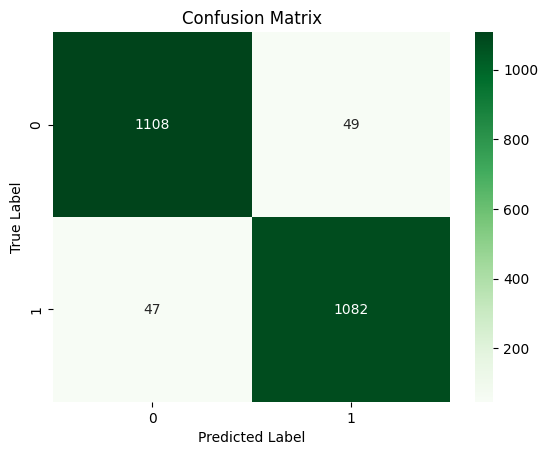

In [ ]:
sns.heatmap(nn_conf_matrix,annot=True, fmt = 'd',cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
nn_report = classification_report(y_test,nn_predict)
print(nn_report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1157
           1       0.96      0.96      0.96      1129

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286



# CNN

In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/dataset_phishing.csv')

# Display the first few rows of the dataset
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Assuming 'url' is the column containing URLs and 'status' is the column containing labels
X = df['url']
y = df['status']  # Assuming 'status' column contains 'legitimate' and 'phishing'

# Convert labels to binary values
y = y.apply(lambda x: 1 if x == 'phishing' else 0)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize URLs
tokenizer = Tokenizer(char_level=True)  # Character-level tokenization
tokenizer.fit_on_texts(X_train)

# Convert URLs to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform input size
max_length = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
embedding_dim = 50  # Embedding dimension

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1641, 50)          3650      
                                                                 
 conv1d (Conv1D)             (None, 1637, 128)         32128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 37079 (144.84 KB)
Trainable params: 37079 (144.84 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
history = model.fit(X_train_pad, y_train, epochs=3
                    , validation_data=(X_test_pad, y_test), batch_size=32)

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy*100:.2f}%')

Epoch 1/3
286/286 [==============================] - 118s 410ms/step - loss: 0.4650 - accuracy: 0.7823 - val_loss: 0.3405 - val_accuracy: 0.8561
Epoch 2/3
286/286 [==============================] - 95s 332ms/step - loss: 0.2874 - accuracy: 0.8797 - val_loss: 0.2614 - val_accuracy: 0.8898
Epoch 3/3
72/72 [==============================] - 5s 68ms/step - loss: 0.2305 - accuracy: 0.9086
Test Accuracy: 90.86%


In [ ]:
# Calculate predicted probabilities
y_pred_proba = model.predict(X_test_pad)

y_pred = (y_pred_proba > 0.5).astype(int)

model_Accuracy_Score = accuracy_score(y_test, y_pred)
model_Jaccard_Index = jaccard_score(y_test, y_pred, pos_label= 1)  # Assuming 'phishing' is the positive class
model_F1_Score = f1_score(y_test, y_pred, pos_label= 1)  # Assuming 'phishing' is the positive class
model_Log_Loss = log_loss(y_test, y_pred_proba)
model_Precision = precision_score(y_test, y_pred, pos_label=1)  # Assuming 'phishing' is the positive class
model_Recall = recall_score(y_test, y_pred, pos_label=1)

72/72 [==============================] - 5s 65ms/step


In [ ]:
model_Accuracy_Score = accuracy_score(y_test, y_pred)
model_Jaccard_Index = jaccard_score(y_test, y_pred, pos_label= 1)  # Assuming 'phishing' is the positive class
model_F1_Score = f1_score(y_test, y_pred, pos_label= 1)  # Assuming 'phishing' is the positive class
model_Log_Loss = log_loss(y_test, y_pred_proba)
model_Precision = precision_score(y_test, y_pred, pos_label=1)  # Assuming 'phishing' is the positive class
model_Recall = recall_score(y_test, y_pred, pos_label=1)


In [ ]:
print(f"Accuracy: {model_Accuracy_Score}")
print(f"Jaccard Index: {model_Jaccard_Index}")
print(f"F1 Score: {model_F1_Score}")
print(f"Log Loss: {model_Log_Loss}")
print(f"Precision:{model_Precision}")
print(f"Recall: {model_Recall}")

Accuracy: 0.9085739282589677
Jaccard Index: 0.823181049069374
F1 Score: 0.9030162412993039
Log Loss: 0.23051867504696547
Precision:0.9483430799220273
Recall: 0.8618246235606731


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True,
)

In [ ]:
report = classification_report(y_test, y_pred, target_names=['Legitimate', 'Phishing'])
print(report)

              precision    recall  f1-score   support

  Legitimate       0.88      0.95      0.91      1157
    Phishing       0.95      0.86      0.90      1129

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



## Model Accurancy

Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')
Best Validation Loss: 0.2305
Best Validation Accuracy: 0.9086


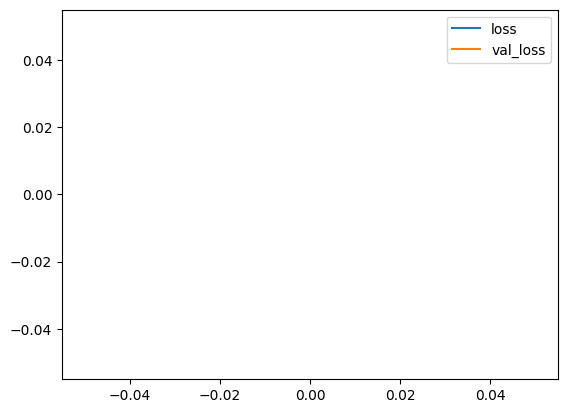

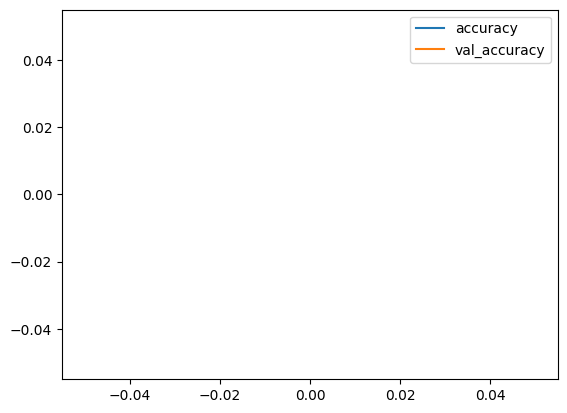

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 50
history_df.loc[50:, ['loss', 'val_loss']].plot()

# Check the actual metric names in your history
print(history_df.columns)

# Assuming the correct metric names are 'accuracy' and 'val_accuracy', use:
history_df.loc[50:, ['accuracy', 'val_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(),
              history_df['val_accuracy'].max()))

In [ ]:
accuracy_scores = {
    'Random Forest' : round(accuracy_score(y_test,rf_predict), 2),
'SVM' : round(accuracy_score(y_test,svm_predict), 2),
    'XGBoost' : round(accuracy_score(y_test,xgb_predict), 2),
    'Decision Tree'  : round(accuracy_score(y_test,tree_predict), 2),
    'Neural Network' : round(accuracy_score(y_test,nn_predict), 2),
    'CNN' : round(history_df['val_accuracy'].max(), 2)
}

In [ ]:
accuracy_df = pd.DataFrame(list(accuracy_scores.items()), columns=['Model', 'Accuracy Score'])
accuracy_df

,Model,Accuracy Score
0,Random Forest,0.96
1,SVM,0.97
2,XGBoost,0.95
3,Decision Tree,0.91
4,Neural Network,0.96
5,CNN,0.91


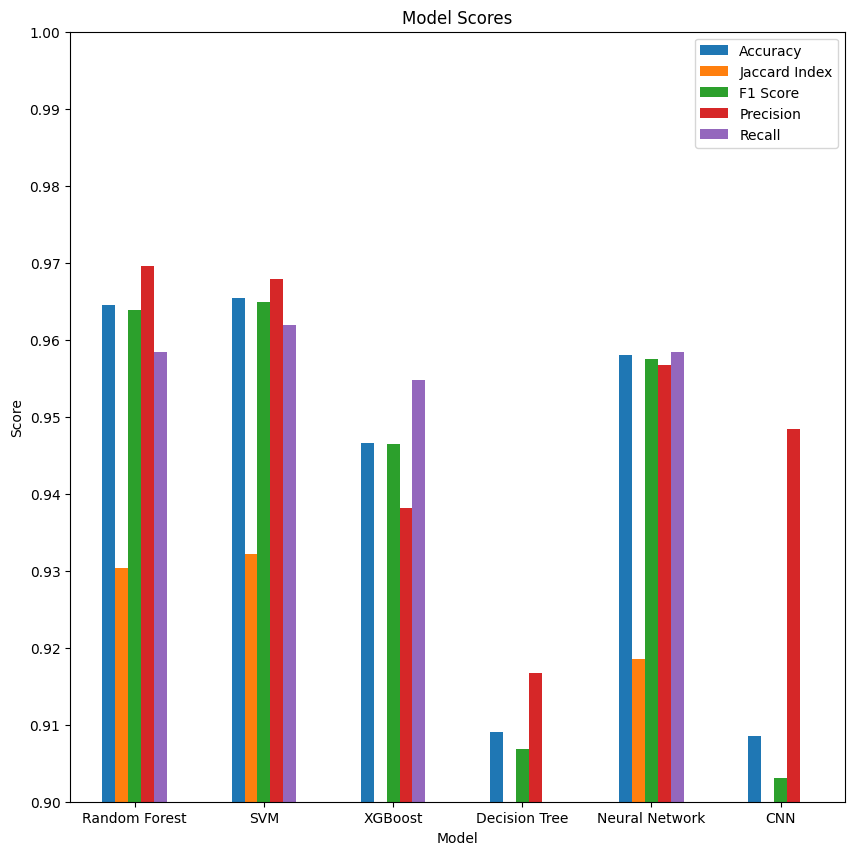

In [ ]:
df = pd.DataFrame({
    'Modelname': ['Random Forest', 'SVM', 'XGBoost', 'Decision Tree', 'Neural Network','CNN'],
    'Accuracy': [
        accuracy_score(y_test, rf_predict),
        accuracy_score(y_test, svm_predict),
        accuracy_score(y_test, xgb_predict),
        accuracy_score(y_test, tree_predict),  # Assuming you have tree_predict
        accuracy_score(y_test, nn_predict),
        model_Accuracy_Score
    ]
})




# Calculate additional metrics for each model (using 2 positional arguments)
df['Jaccard Index'] = [
    jaccard_score(y_test, rf_predict),
    jaccard_score(y_test, svm_predict),
    jaccard_score(y_test, xgb_predict),
    jaccard_score(y_test, tree_predict),
    jaccard_score(y_test, nn_predict),
    model_Jaccard_Index
]


df['F1 Score'] = [
    f1_score(y_test, rf_predict),
    f1_score(y_test, svm_predict),
    f1_score(y_test, xgb_predict),
    f1_score(y_test, tree_predict),
    f1_score(y_test, nn_predict),
    model_F1_Score
]

# ... (Log Loss calculations - might not be directly applicable to CNN)

df['Precision'] = [
    precision_score(y_test, rf_predict),
    precision_score(y_test, svm_predict),
    precision_score(y_test, xgb_predict),
    precision_score(y_test, tree_predict),
    precision_score(y_test, nn_predict),
    model_Precision
]

df['Recall'] = [
    recall_score(y_test, rf_predict),
    recall_score(y_test, svm_predict),
    recall_score(y_test, xgb_predict),
    recall_score(y_test, tree_predict),
    recall_score(y_test, nn_predict),
    model_Recall
]

df.set_index('Modelname', inplace=True)

# plot the scores for each model
# ... (rest of your plotting code)




# plot the scores for each model

fig, ax = plt.subplots(figsize=(10,10))
df.plot(kind='bar', ax=ax)
ax.set_xticklabels(df.index, rotation=0)
ax.set_ylim([0.9, 1])
ax.set_yticks([0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1])
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Scores')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
